In [1]:
import pandas as pd
from datetime import datetime
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Load the data

In [2]:
csvs = os.listdir('accepted/')

In [3]:
# make sure all csv files have the same headers
with open("accepted/"+csvs[0], 'r') as f:
    columns = f.readlines()[0]
for c in csvs[1:]:
    with open("accepted/" + c, 'r') as f:
        if f.readlines()[0] != columns:
            print(c)

In [4]:
dtype = {'id':str,'member_id':str,'loan_amnt':float,'funded_amnt':float,'funded_amnt_inv':float,
         'term':str,'int_rate':str,
         'installment':float,'grade':str,'sub_grade':str,'emp_title':str,'emp_length':str,'home_ownership':str,
         'annual_inc':float,'verification_status':str,'issue_d':str,'loan_status':str,'pymnt_plan':str,'url':str,
         'desc':str,'purpose':str,'title':str,'zip_code':str,'addr_state':str,'dti':float,'delinq_2yrs':float,
         'earliest_cr_line':str,'inq_last_6mths':float,'mths_since_last_delinq':float,
         'mths_since_last_record':float,
         'open_acc':float,'pub_rec':float,'revol_bal':float,'total_acc':float,'initial_list_status':str,
         'out_prncp':float,
         'out_prncp_inv':float,'total_pymnt':float,'total_pymnt_inv':float,'total_rec_prncp':float,
         'total_rec_int':float,
         'total_rec_late_fee':float,'recoveries':float,'collection_recovery_fee':float,'last_pymnt_d':str,
         'last_pymnt_amnt':float,'next_pymnt_d':str,'last_credit_pull_d':str,'collections_12_mths_ex_med':float,
         'mths_since_last_major_derog':float,'policy_code':str,'application_type':str,'annual_inc_joint':float,
         'dti_joint':float,'verification_status_joint':str,'acc_now_delinq':float,'tot_coll_amt':float,
         'tot_cur_bal':float,
         'open_acc_6m':float,'open_act_il':float,'open_il_12m':float,'open_il_24m':float,
         'mths_since_rcnt_il':float,'total_bal_il':float,
         'il_util':str,'open_rv_12m':float,'open_rv_24m':float,'max_bal_bc':float,'all_util':float,
         'total_rev_hi_lim':float,
         'inq_fi':float,'total_cu_tl':float,'inq_last_12m':float,'acc_open_past_24mths':float,'avg_cur_bal':float,
         'bc_open_to_buy':str,'bc_util':str,'chargeoff_within_12_mths':float,'delinq_amnt':float,
         'mo_sin_old_il_acct':str,
         'mo_sin_old_rev_tl_op':str,'mo_sin_rcnt_rev_tl_op':str,'mo_sin_rcnt_tl':str,'mort_acc':float,
         'mths_since_recent_bc':float,'mths_since_recent_bc_dlq':float,'mths_since_recent_inq':float,
         'mths_since_recent_revol_delinq':float,
         'num_accts_ever_120_pd':float,'num_actv_bc_tl':float,'num_actv_rev_tl':float,'num_bc_sats':float,
         'num_bc_tl':float,
         'num_il_tl':float,'num_op_rev_tl':float,'num_rev_accts':float,'num_rev_tl_bal_gt_0':float,'num_sats':float,
         'num_tl_120dpd_2m':float,'num_tl_30dpd':float,'num_tl_90g_dpd_24m':float,'num_tl_op_past_12m':float,
         'pct_tl_nvr_dlq':float,'percent_bc_gt_75':float,'pub_rec_bankruptcies':float,'tax_liens':float,
         'tot_hi_cred_lim':float,
         'total_bal_ex_mort':float,'total_bc_limit':float,'total_il_high_credit_limit':float,'revol_bal_joint':float,
         'sec_app_earliest_cr_line':str,'sec_app_inq_last_6mths':float,'sec_app_mort_acc':str,'sec_app_open_acc':str,
         'sec_app_revol_util':str,'sec_app_open_act_il':str,'sec_app_num_rev_accts':float,
         'sec_app_chargeoff_within_12_mths':float,
         'sec_app_collections_12_mths_ex_med':float,'sec_app_mths_since_last_major_derog':float,'hardship_flag':str,
         'hardship_type':str,'hardship_reason':str,'hardship_status':str,'deferral_term':str,'hardship_amount':float,
         'hardship_start_date':str,'hardship_end_date':str,'payment_plan_start_date':str,'hardship_length':str,
         'hardship_dpd':float,'hardship_loan_status':str,'orig_projected_additional_accrued_interest':float,
         'hardship_payoff_balance_amount':float,'hardship_last_payment_amount':float,'disbursement_method':str,
         'debt_settlement_flag':str,'debt_settlement_flag_date':str,'settlement_status':str,'settlement_date':str,
         'settlement_amount':float,'settlement_percentage':float,'settlement_term':str}

In [5]:
df = pd.DataFrame(columns=dtype.keys())
for i,c in enumerate(csvs):
    df = df.append(pd.read_csv("accepted/" + c, dtype=dtype))

In [6]:
print("number of data points: {}".format(len(df)))

number of data points: 1765451


### Drop current and unlabeled borrowers

In [7]:
print(df.loan_status.value_counts(normalize=True))

Current                                                0.523060
Fully Paid                                             0.357402
Charged Off                                            0.091091
Late (31-120 days)                                     0.014585
In Grace Period                                        0.009283
Late (16-30 days)                                      0.002981
Does not meet the credit policy. Status:Fully Paid     0.001126
Does not meet the credit policy. Status:Charged Off    0.000431
Default                                                0.000041
Name: loan_status, dtype: float64


We drop current borrowers, as we are primarily interested in those who have already paid off or charged off on their loans. We save the current borrowers to predict how they will behave for future projects. Note that "Charged Off" means no further payment is expected. This typically occurs when a payment is 150+ days past due. "Default" typically means the borrower has not made a payment for 121+ days, but the account has not been closed or sent to collections yet (see https://help.lendingclub.com/hc/en-us/articles/216127747-What-is-the-difference-between-a-loan-that-is-in-default-and-a-loan-that-has-been-charged-off-).

The labels that include "Does not meet the credit policy" means those applicants would not be awarded a loan under Lending Club's current policy. We omit them from this analysis, as we are concerned with the current policy of Lending Club.

In [8]:
# save current borrowers for separate analysis
current_df = df[(df.loan_status != 'Fully Paid') & (df.loan_status != 'Charged Off') 
                & (df.loan_status != 'Does not meet the credit policy. Status:Fully Paid')
                & (df.loan_status != 'Does not meet the credit policy. Status:Charged Off')]

In [9]:
current_df.to_csv("data/current_borrowers.csv", index=False)

We drop the unlabeled data points, as the proportion of unlabeled points (about .003%) is marginal.

In [10]:
print("number of unlabeled points: {}".format(len(df) - df.loan_status.value_counts().sum()))

number of unlabeled points: 25


In [11]:
# drop unlabeled data points (nan)
df = df.dropna(subset=['loan_status'])
len(df)

1765426

In [12]:
unqualified_df = df[df.loan_status.str.contains("Does not meet the credit policy")]
len(unqualified_df)

2749

In [13]:
# save those who don't meet the policy today in a separate csv
unqualified_df.to_csv("data/unqualified_df.csv", index=False)
df = df[(df.loan_status != 'Does not meet the credit policy. Status:Fully Paid') & 
        (df.loan_status != 'Does not meet the credit policy. Status:Charged Off')]
len(df)

1762677

In [14]:
# drop current borrowers
df = df[df.loan_status!='Current']
df = df[df.loan_status!='In Grace Period']
df = df[df.loan_status!='Late (31-120 days)']
df = df[df.loan_status!='Late (16-30 days)']
df = df[df.loan_status!='Default']

In [15]:
print(df.loan_status.unique())

['Fully Paid' 'Charged Off']


In [16]:
df.loan_status.value_counts(normalize=True)

Fully Paid     0.796896
Charged Off    0.203104
Name: loan_status, dtype: float64

Observations labeled with "Does not meet the credit policy" are people that borrowed from Lending Club in the past, but would not currently qualify for a loan under Lending Club's current policy. We save them as a separate dataframe for further analysis; perhaps we can identify the change in Lending Club's policy that would cause those borrowers to not qualify for a loan today.

### Label the data

In [17]:
df.loan_status = df.loan_status.map({'Fully Paid':0, 'Charged Off':1})
df.to_csv('data/labeled.csv', index=False)

In [18]:
# change loan_status to int, due to encoded labels
dtype['loan_status'] = int
df = pd.read_csv('data/labeled.csv', dtype=dtype)
len(df.columns)

145

### Remove features that are not available for new applicants

Since we want to this analysis to be useful for new applicants, we drop the columns that are available for only those whose applications have been accepted and have already received the loan for which they applied. Many of these features have to do with payment schedules, recovery fees, and hardship plans.

In [19]:
feats = ['collection_recovery_fee', 'funded_amnt', 'funded_amnt_inv', 'issue_d', 'last_credit_pull_d',
         'last_pymnt_amnt', 'last_pymnt_d', 'next_pymnt_d', 'out_prncp', 'out_prncp_inv', 'pymnt_plan',
         'recoveries', 'term', 'total_pymnt', 'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee',
         'total_rec_prncp', 'hardship_flag', 'hardship_type', 'hardship_reason', 'hardship_status',
         'deferral_term', 'hardship_amount', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date',
         'hardship_length', 'hardship_dpd', 'hardship_loan_status', 'orig_projected_additional_accrued_interest',
         'hardship_payoff_balance_amount', 'hardship_last_payment_amount', 'disbursement_method', 
         'debt_settlement_flag', 'debt_settlement_flag_date', 'settlement_status', 'settlement_date',
         'settlement_amount', 'settlement_percentage', 'settlement_term']
df.drop(feats, axis=1, inplace=True)

### Remove uniform columns

In [20]:
# find features with uniform values
for col in df.columns:
    if len(df[col].unique()) == 1:
        print(col, len(df[col].unique()))
        df.drop(col, axis=1, inplace=True)

id 1
member_id 1
policy_code 1
url 1


In [21]:
df.shape

(791781, 100)

### Remove nearly uniform columns (99% or more one value)

In [22]:
df.application_type.value_counts(normalize=True)

Individual    0.995332
Joint App     0.004668
Name: application_type, dtype: float64

In [23]:
df.drop('application_type', axis=1, inplace=True)

In [24]:
df.num_tl_120dpd_2m.value_counts(normalize=True)

0.0    0.999187
1.0    0.000779
2.0    0.000029
3.0    0.000004
6.0    0.000001
Name: num_tl_120dpd_2m, dtype: float64

In [25]:
df.drop('num_tl_120dpd_2m', axis=1, inplace=True)

In [26]:
df.num_tl_30dpd.value_counts(normalize=True)

0.0    0.996822
1.0    0.003021
2.0    0.000130
3.0    0.000021
4.0    0.000007
Name: num_tl_30dpd, dtype: float64

In [27]:
df.drop('num_tl_30dpd', axis=1, inplace=True)

In [28]:
df.num_tl_90g_dpd_24m.value_counts(normalize=True).iloc[:10]

0.0    0.943032
1.0    0.042586
2.0    0.008732
3.0    0.002325
4.0    0.001283
5.0    0.000639
6.0    0.000453
7.0    0.000279
8.0    0.000186
9.0    0.000135
Name: num_tl_90g_dpd_24m, dtype: float64

In [29]:
df.drop('num_tl_90g_dpd_24m', axis=1, inplace=True)

In [30]:
df.chargeoff_within_12_mths.value_counts(normalize=True).iloc[:10]

0.0     0.992371
1.0     0.006899
2.0     0.000595
3.0     0.000091
4.0     0.000025
5.0     0.000009
7.0     0.000004
6.0     0.000004
8.0     0.000001
10.0    0.000001
Name: chargeoff_within_12_mths, dtype: float64

In [31]:
df.drop('chargeoff_within_12_mths', axis=1, inplace=True)

In [32]:
df.collections_12_mths_ex_med.value_counts(normalize=True).iloc[:10]

0.0     0.986950
1.0     0.012137
2.0     0.000782
3.0     0.000082
4.0     0.000028
6.0     0.000008
5.0     0.000006
12.0    0.000003
7.0     0.000001
20.0    0.000001
Name: collections_12_mths_ex_med, dtype: float64

In [33]:
df.drop('collections_12_mths_ex_med', axis=1, inplace=True)

In [34]:
df.tax_liens.value_counts(normalize=True).iloc[:10]

0.0    0.971738
1.0    0.019566
2.0    0.005166
3.0    0.001782
4.0    0.000802
5.0    0.000416
6.0    0.000227
7.0    0.000111
8.0    0.000054
9.0    0.000043
Name: tax_liens, dtype: float64

In [35]:
df.drop('tax_liens', axis=1, inplace=True)

In [36]:
df.acc_now_delinq.value_counts(normalize=True)

0.0    0.995499
1.0    0.004247
2.0    0.000215
3.0    0.000027
4.0    0.000009
5.0    0.000003
6.0    0.000001
Name: acc_now_delinq, dtype: float64

In [37]:
df.drop('acc_now_delinq', axis=1, inplace=True)

### Remove columns with a majority (70% or more) of missing values

In [38]:
null_counts = dict(df.isnull().sum())
null_cols = []
for key,val in null_counts.items():
    if val/df.shape[0] >= .7:
        print("{:<35}\t{}".format((key), val/df.shape[0]))
    if val/df.shape[0] >= 0.7:
        null_cols.append(key)

all_util                           	0.7903877461065623
annual_inc_joint                   	0.995332042572378
desc                               	0.8491161066001837
dti_joint                          	0.995332042572378
il_util                            	0.8168483456915485
inq_fi                             	0.790373853376123
inq_last_12m                       	0.7903751163516174
max_bal_bc                         	0.790373853376123
mths_since_last_major_derog        	0.7493372536092682
mths_since_last_record             	0.8365583412585046
mths_since_rcnt_il                 	0.7950165512938553
mths_since_recent_bc_dlq           	0.7683803981151354
open_acc_6m                        	0.7903751163516174
open_act_il                        	0.790373853376123
open_il_12m                        	0.790373853376123
open_il_24m                        	0.790373853376123
open_rv_12m                        	0.790373853376123
open_rv_24m                        	0.790373853376123
revol_bal_joint    

In [39]:
print(len(null_cols))
df.drop(null_cols, axis=1, inplace=True)
print(len(df.columns))

32
60


### Drop columns that aren't helpful or are strongly correlated with other features

In [40]:
df['zip_code'].head()

0    775xx
1    985xx
2    333xx
3    770xx
4    760xx
Name: zip_code, dtype: object

In [41]:
# drop the zip_code feature, since we can't work with 3-digit zip codes, and addr_state gives the state
df.drop("zip_code", axis=1, inplace=True)

In [42]:
df.drop('addr_state', axis=1, inplace=True)

In [43]:
df['title'].head(10)

0         Debt consolidation
1         Debt consolidation
2           Home improvement
3         Debt consolidation
4         Debt consolidation
5             Major purchase
6    Credit card refinancing
7      Moving and relocation
8         Debt consolidation
9                      Other
Name: title, dtype: object

In [44]:
# make lower case
df['title'] = df['title'].str.lower()
# got rid of about 10000 categories
print(len(df['title'].unique()))
print(df['title'].isnull().sum())

50798
7387


In [45]:
# keep top x categories
# use substring matching to combine categories (other ways to combine categories)
# make new categories for leftovers
print(len(df['title'].unique()))
df['title'].value_counts(normalize=True).iloc[:15]

50798


debt consolidation           0.482650
credit card refinancing      0.163981
home improvement             0.051340
other                        0.041199
major purchase               0.015564
consolidation                0.009329
medical expenses             0.008617
business                     0.008354
car financing                0.007036
debt consolidation loan      0.005771
vacation                     0.005375
moving and relocation        0.005240
credit card consolidation    0.004281
personal loan                0.004013
home buying                  0.003573
Name: title, dtype: float64

In [46]:
df['purpose'].value_counts(normalize=True)

debt_consolidation    0.590490
credit_card           0.214485
home_improvement      0.062402
other                 0.054115
major_purchase        0.021540
small_business        0.012631
car                   0.011061
medical               0.010753
moving                0.007041
vacation              0.006292
house                 0.005166
wedding               0.002868
renewable_energy      0.000744
educational           0.000412
Name: purpose, dtype: float64

In [47]:
# drop title (for now), as purpose is a more uniform, consistent way to measure a similar thing (high correlation)
df.drop('title', axis=1, inplace=True)

In [48]:
df.emp_title.head()

0             Buyer
1               USA
2               NaN
3               NaN
4    member service
Name: emp_title, dtype: object

In [49]:
len(df.emp_title.unique())

275475

In [50]:
# for similar reasoning, drop emp_title (user input, very messy)
df.drop('emp_title', axis=1, inplace=True)

In [51]:
df.grade.value_counts(normalize=True)

B    0.288935
C    0.276340
A    0.163899
D    0.156993
E    0.078034
F    0.028402
G    0.007397
Name: grade, dtype: float64

In [52]:
df.sub_grade.value_counts(normalize=True)

B3    0.063241
B4    0.062870
C1    0.061520
C2    0.058502
B5    0.058317
B2    0.054934
C3    0.054861
C4    0.053442
B1    0.049573
C5    0.048016
A5    0.046678
D1    0.040097
A4    0.038796
D2    0.034604
D3    0.030087
D4    0.028502
A1    0.026889
A3    0.026525
A2    0.025011
D5    0.023704
E1    0.020006
E2    0.018178
E3    0.015271
E4    0.013143
E5    0.011438
F1    0.008730
F2    0.006488
F3    0.005491
F4    0.004294
F5    0.003399
G1    0.002464
G2    0.001841
G3    0.001321
G4    0.000976
G5    0.000794
Name: sub_grade, dtype: float64

In [53]:
df.grade = df.sub_grade.apply(lambda x: x[0] if x[0]=='E' or x[0]=='F' or x[0]=='G' else x)

In [54]:
df.grade.value_counts(normalize=True)

E     0.078034
B3    0.063241
B4    0.062870
C1    0.061520
C2    0.058502
B5    0.058317
B2    0.054934
C3    0.054861
C4    0.053442
B1    0.049573
C5    0.048016
A5    0.046678
D1    0.040097
A4    0.038796
D2    0.034604
D3    0.030087
D4    0.028502
F     0.028402
A1    0.026889
A3    0.026525
A2    0.025011
D5    0.023704
G     0.007397
Name: grade, dtype: float64

In [55]:
# drop sub_grade, as that information can be captured in our engineered grade
df.drop('sub_grade', axis=1, inplace=True)

### Clean features and change to floats/ints

In [56]:
df['revol_util'].head()

0    50.9%
1    45.6%
2    11.9%
3       5%
4    92.6%
Name: revol_util, dtype: object

In [57]:
# change revol_util to floats
df.revol_util = df.revol_util.str[:-1].astype('float')/100
df.revol_util.head()

0    0.509
1    0.456
2    0.119
3    0.050
4    0.926
Name: revol_util, dtype: float64

In [58]:
# change earliest_cr_line to year so we can easily use it
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line']).dt.year

We keep interest rate, as it is calculated based off the grade which Lending Club gives an applicant. The method of grade assignment is explained in this link: https://www.lendingclub.com/foliofn/rateDetail.action.

In [59]:
df['int_rate'].head()

0     13.99%
1     14.49%
2      5.32%
3     12.79%
4     13.99%
Name: int_rate, dtype: object

In [60]:
df.int_rate = df.int_rate.str[:-1].astype('float')/100
df.int_rate.head()

0    0.1399
1    0.1449
2    0.0532
3    0.1279
4    0.1399
Name: int_rate, dtype: float64

In [61]:
df.bc_util = df.bc_util.astype('float')

In [62]:
df.bc_util.tail(10)

791771    76.3
791772    44.4
791773    22.2
791774    70.0
791775    78.7
791776    55.6
791777    24.6
791778     NaN
791779    18.2
791780    13.1
Name: bc_util, dtype: float64

In [63]:
df.bc_open_to_buy = df.bc_open_to_buy.astype('float')

In [64]:
df.dtypes.unique()

array([dtype('float64'), dtype('int64'), dtype('O')], dtype=object)

In [65]:
df.select_dtypes(include=['O']).columns

Index(['emp_length', 'grade', 'home_ownership', 'initial_list_status',
       'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op',
       'mo_sin_rcnt_tl', 'purpose', 'verification_status'],
      dtype='object')

In [66]:
df['emp_length'].head()

0      4 years
1    10+ years
2          n/a
3          n/a
4    10+ years
Name: emp_length, dtype: object

In [67]:
df['emp_length'] = df['emp_length'].apply(lambda x: -1 if x=='n/a' else 0 if x[0]=='<' else int(x[0]))

In [68]:
df['grade'].astype('category').cat.codes.value_counts(normalize=True)

20    0.078034
7     0.063241
8     0.062870
10    0.061520
11    0.058502
9     0.058317
6     0.054934
12    0.054861
13    0.053442
5     0.049573
14    0.048016
4     0.046678
15    0.040097
3     0.038796
16    0.034604
17    0.030087
18    0.028502
21    0.028402
0     0.026889
2     0.026525
1     0.025011
19    0.023704
22    0.007397
dtype: float64

In [69]:
df['grade'] = df['grade'].astype('category').cat.codes

In [70]:
df['home_ownership'].value_counts(normalize=True)

MORTGAGE    0.499499
RENT        0.398807
OWN         0.101346
OTHER       0.000182
ANY         0.000111
NONE        0.000054
Name: home_ownership, dtype: float64

In [71]:
ownership_dict = {'MORTGAGE':0, 'RENT': 1, 'OWN': 2, 'OTHER': 3, 'ANY': 4, 'NONE': 5}
df.home_ownership = df.home_ownership.map(ownership_dict)

In [72]:
df['initial_list_status'].value_counts(normalize=True)

f    0.511563
w    0.488437
Name: initial_list_status, dtype: float64

In [73]:
df['initial_list_status'] = df['initial_list_status'].astype('category').cat.codes

In [74]:
df['mo_sin_old_il_acct'] = df['mo_sin_old_il_acct'].astype(float)
df['mo_sin_old_rev_tol_op'] = df['mo_sin_old_rev_tl_op'].astype(float)
df['mo_sin_rcnt_rev_tl_op'] = df['mo_sin_rcnt_rev_tl_op'].astype(float)
df['mo_sin_rcnt_tl'] = df['mo_sin_rcnt_tl'].astype(float)
df['mo_sin_old_rev_tl_op'] = df['mo_sin_old_rev_tl_op'].astype(float)

In [75]:
df['purpose'].value_counts(normalize=True)

debt_consolidation    0.590490
credit_card           0.214485
home_improvement      0.062402
other                 0.054115
major_purchase        0.021540
small_business        0.012631
car                   0.011061
medical               0.010753
moving                0.007041
vacation              0.006292
house                 0.005166
wedding               0.002868
renewable_energy      0.000744
educational           0.000412
Name: purpose, dtype: float64

In [76]:
df['purpose'].astype('category').cat.codes.value_counts(normalize=True)

2     0.590490
1     0.214485
4     0.062402
9     0.054115
6     0.021540
11    0.012631
0     0.011061
7     0.010753
8     0.007041
12    0.006292
5     0.005166
13    0.002868
10    0.000744
3     0.000412
dtype: float64

In [77]:
df['purpose'] = df['purpose'].astype('category').cat.codes

In [78]:
df['verification_status'].value_counts(normalize=True)

Source Verified    0.359320
Verified           0.331655
Not Verified       0.309025
Name: verification_status, dtype: float64

In [79]:
df['verification_status'] = df['verification_status'].astype('category').cat.codes

In [80]:
df.dtypes.unique()

array([dtype('float64'), dtype('int64'), dtype('int8')], dtype=object)

In [81]:
print(df.columns[df.isnull().any()], len(df.columns[df.isnull().any()]))

Index(['acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'dti', 'inq_last_6mths', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
       'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
       'mths_since_last_delinq', 'mths_since_recent_bc',
       'mths_since_recent_inq', 'mths_since_recent_revol_delinq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats',
       'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75',
       'pub_rec_bankruptcies', 'revol_util', 'tot_coll_amt', 'tot_cur_bal',
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit', 'total_rev_hi_lim',
       'mo_sin_old_rev_tol_op'],
      dtype='object') 38


In [82]:
# save the work we've done thus far
df.to_csv("data/cleaned_features.csv", index=False)

### Create train/test split and fill missing values

In [90]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('loan_status', axis=1), 
                                                    df['loan_status'], test_size=.25)

In [91]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((593835, 55), (593835,), (197946, 55), (197946,))

In [93]:
print(y_train.value_counts(normalize=True), '\n', y_test.value_counts(normalize=True))

0    0.796499
1    0.203501
Name: loan_status, dtype: float64 
 0    0.798086
1    0.201914
Name: loan_status, dtype: float64


In [94]:
def describe_missing(var):
    print(X_train[var].isnull().sum()/X_train.shape[0])
    print(X_train[var].describe())
    print(y_train[X_train[var].isnull()].value_counts(normalize=True))
    X_train[var].hist(bins=15, normed=True)
    plt.show()

#### `mths_since_recent_revol_delinq`

In [95]:
# find column with most missing values
X_train.count().idxmin()

'mths_since_recent_revol_delinq'

0.674978739886
count    193009.000000
mean         36.160547
std          22.411247
min           0.000000
25%          17.000000
50%          33.000000
75%          53.000000
max         176.000000
Name: mths_since_recent_revol_delinq, dtype: float64
0    0.800425
1    0.199575
Name: loan_status, dtype: float64


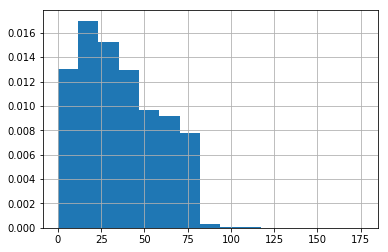

In [96]:
describe_missing('mths_since_recent_revol_delinq')

We fill missing values in `mth_since_recent_revol_delinq` with the rounded mean, as all the values are integers.

In [97]:
X_test['mths_since_recent_revol_delinq'].fillna(np.round(X_train['mths_since_recent_revol_delinq'].mean()), inplace=True)
X_train['mths_since_recent_revol_delinq'].fillna(np.round(X_train['mths_since_recent_revol_delinq'].mean()), inplace=True)

#### `mths_since_last_delinq`

In [98]:
# find column with most missing values
X_train.count().idxmin()

'mths_since_last_delinq'

0.513166115167
count    289099.000000
mean         34.484917
std          21.913036
min           0.000000
25%          16.000000
50%          31.000000
75%          50.000000
max         192.000000
Name: mths_since_last_delinq, dtype: float64
0    0.803079
1    0.196921
Name: loan_status, dtype: float64


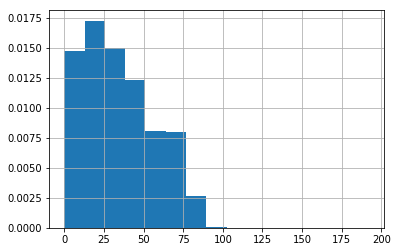

In [99]:
describe_missing('mths_since_last_delinq')

Similarly, we fill missing values in `mth_since_last_delinq` with the rounded mean, as all the values are integers.

In [100]:
X_test['mths_since_last_delinq'].fillna(np.round(X_train['mths_since_last_delinq'].mean()), inplace=True)
X_train['mths_since_last_delinq'].fillna(np.round(X_train['mths_since_last_delinq'].mean()), inplace=True)

#### `mths_since_recent_inq`

In [101]:
# find column with most missing values
X_train.count().idxmin()

'mths_since_recent_inq'

0.145425917974
count    507476.000000
mean          6.598765
std           5.800788
min           0.000000
25%           2.000000
50%           5.000000
75%          10.000000
max          25.000000
Name: mths_since_recent_inq, dtype: float64
0    0.847173
1    0.152827
Name: loan_status, dtype: float64


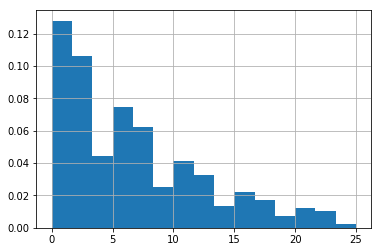

In [102]:
describe_missing('mths_since_recent_inq')

Similarly, we fill missing values in `mth_since_recent_inq` with the rounded mean, as all the values are integers.

In [103]:
X_test['mths_since_recent_inq'].fillna(np.round(X_train['mths_since_recent_inq'].mean()), inplace=True)
X_train['mths_since_recent_inq'].fillna(np.round(X_train['mths_since_recent_inq'].mean()), inplace=True)

#### `mo_sin_old_il_acct`

In [104]:
# find column with most missing values
X_train.count().idxmin()

'mo_sin_old_il_acct'

0.112248351815
count    527178.000000
mean        125.874786
std          51.561097
min           0.000000
25%          98.000000
50%         129.000000
75%         152.000000
max         724.000000
Name: mo_sin_old_il_acct, dtype: float64
0    0.82947
1    0.17053
Name: loan_status, dtype: float64


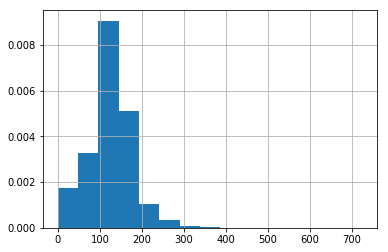

In [105]:
describe_missing('mo_sin_old_il_acct')

We fill missing values in `pct_tl_nvr_dlq` with the rounded mean to one decimal place to match the format of the other values.

In [106]:
X_test['mo_sin_old_il_acct'].fillna(np.round(X_train['mo_sin_old_il_acct'].mean(), 1), inplace=True)
X_train['mo_sin_old_il_acct'].fillna(np.round(X_train['mo_sin_old_il_acct'].mean(), 1), inplace=True)

#### `pct_tl_nvr_dlq`

In [107]:
# find column with most missing values
X_train.count().idxmin()

'pct_tl_nvr_dlq'

0.0854951291184
count    543065.000000
mean         94.397781
std           8.387664
min           0.000000
25%          91.700000
50%          98.100000
75%         100.000000
max         100.000000
Name: pct_tl_nvr_dlq, dtype: float64
0    0.845952
1    0.154048
Name: loan_status, dtype: float64


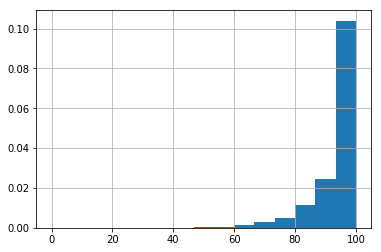

In [108]:
describe_missing('pct_tl_nvr_dlq')

We fill missing values in `pct_tl_nvr_dlq` with the median due to the skew of the data.

In [109]:
X_test['pct_tl_nvr_dlq'].fillna(X_train['pct_tl_nvr_dlq'].median(), inplace=True)
X_train['pct_tl_nvr_dlq'].fillna(X_train['pct_tl_nvr_dlq'].median(), inplace=True)

#### `avg_cur_bal`

In [110]:
# find column with most missing values
X_train.count().idxmin()

'avg_cur_bal'

0.0853452558371
count    543154.000000
mean      13523.054322
std       16201.955877
min           0.000000
25%        3121.000000
50%        7511.000000
75%       18855.000000
max      958084.000000
Name: avg_cur_bal, dtype: float64
0    0.845938
1    0.154062
Name: loan_status, dtype: float64


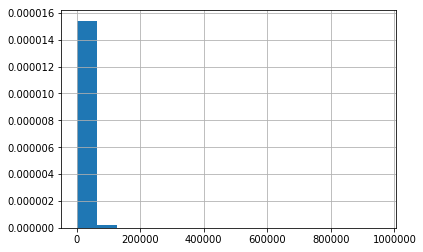

In [111]:
describe_missing('avg_cur_bal')

We fill missing values in `avg_cur_bal` with the median, since the data are highly skewed.

In [112]:
X_test['avg_cur_bal'].fillna(X_train['avg_cur_bal'].median(), inplace=True)
X_train['avg_cur_bal'].fillna(X_train['avg_cur_bal'].median(), inplace=True)

#### `mo_sin_old_rev_tl_op`

In [113]:
# find column with most missing values
X_train.count().idxmin()

'mo_sin_old_rev_tl_op'

0.0853317840814
count    543162.000000
mean        180.768905
std          92.040782
min           2.000000
25%         117.000000
50%         164.000000
75%         228.000000
max         842.000000
Name: mo_sin_old_rev_tl_op, dtype: float64
0    0.845953
1    0.154047
Name: loan_status, dtype: float64


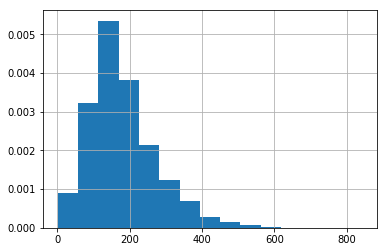

In [114]:
describe_missing('mo_sin_old_rev_tl_op')

We fill missing values in `mo_sin_old_rev_tl_op` with the median since the data are slightly skewed.

In [115]:
X_test['mo_sin_old_rev_tl_op'].fillna(X_train['mo_sin_old_rev_tl_op'].median(), inplace=True)
X_train['mo_sin_old_rev_tl_op'].fillna(X_train['mo_sin_old_rev_tl_op'].median(), inplace=True)

#### `mo_sin_rcnt_rev_tl_op`

In [117]:
# find column with most missing values
X_train.count().idxmin()

'mo_sin_rcnt_rev_tl_op'

0.0853317840814
count    543162.000000
mean         12.687935
std          15.625822
min           0.000000
25%           4.000000
50%           8.000000
75%          15.000000
max         372.000000
Name: mo_sin_rcnt_rev_tl_op, dtype: float64
0    0.845953
1    0.154047
Name: loan_status, dtype: float64


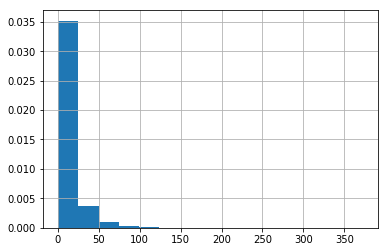

In [118]:
describe_missing('mo_sin_rcnt_rev_tl_op')

We fill missing values in `mo_sin_rcnt_rev_tl_op` with the median.

In [119]:
X_test['mo_sin_rcnt_rev_tl_op'].fillna(X_train['mo_sin_rcnt_rev_tl_op'].median(), inplace=True)
X_train['mo_sin_rcnt_rev_tl_op'].fillna(X_train['mo_sin_rcnt_rev_tl_op'].median(), inplace=True)

#### `num_rev_accts`

In [121]:
# find column with most missing values
X_train.count().idxmin()

'num_rev_accts'

0.0853317840814
count    543162.000000
mean         15.054487
std           8.119425
min           0.000000
25%           9.000000
50%          14.000000
75%          19.000000
max         128.000000
Name: num_rev_accts, dtype: float64
0    0.845973
1    0.154027
Name: loan_status, dtype: float64


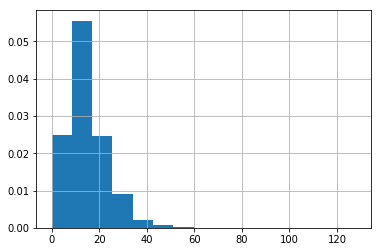

In [122]:
describe_missing('num_rev_accts')

We fill missing values in `num_rev_accts` with the median.

In [123]:
X_test['num_rev_accts'].fillna(X_train['num_rev_accts'].median(), inplace=True)
X_train['num_rev_accts'].fillna(X_train['num_rev_accts'].median(), inplace=True)

#### `mo_sin_old_rev_tol_op`

In [125]:
# find column with most missing values
X_train.count().idxmin()

'mo_sin_old_rev_tol_op'

0.0853317840814
count    543162.000000
mean        180.768905
std          92.040782
min           2.000000
25%         117.000000
50%         164.000000
75%         228.000000
max         842.000000
Name: mo_sin_old_rev_tol_op, dtype: float64
0    0.845953
1    0.154047
Name: loan_status, dtype: float64


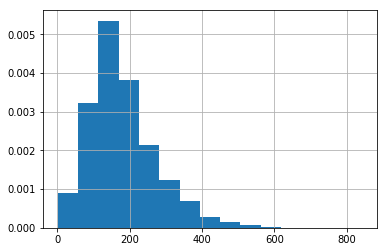

In [126]:
describe_missing('mo_sin_old_rev_tol_op')

We fill missing values in `mo_sin_old_rev_tol_op` with the median, due to the skew.

In [127]:
X_test['mo_sin_old_rev_tol_op'].fillna(X_train['mo_sin_old_rev_tol_op'].median(), inplace=True)
X_train['mo_sin_old_rev_tol_op'].fillna(X_train['mo_sin_old_rev_tol_op'].median(), inplace=True)

#### `mo_sin_rcnt_tl`

In [128]:
# find column with most missing values
X_train.count().idxmin()

'mo_sin_rcnt_tl'

0.085330100112
count    543163.000000
mean          7.678813
std           8.478015
min           0.000000
25%           3.000000
50%           5.000000
75%          10.000000
max         314.000000
Name: mo_sin_rcnt_tl, dtype: float64
0    0.84597
1    0.15403
Name: loan_status, dtype: float64


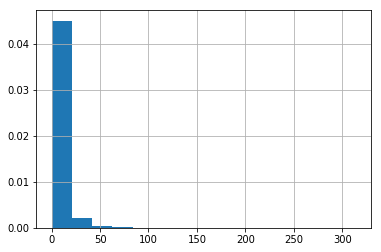

In [129]:
describe_missing('mo_sin_rcnt_tl')

We fill missing values in `mo_sin_rcnt_tl` with the median due to the skew.

In [130]:
X_test['mo_sin_rcnt_tl'].fillna(X_train['mo_sin_rcnt_tl'].median(), inplace=True)
X_train['mo_sin_rcnt_tl'].fillna(X_train['mo_sin_rcnt_tl'].median(), inplace=True)

#### `num_accts_ever_120_pd`

In [131]:
# find column with most missing values
X_train.count().idxmin()

'num_accts_ever_120_pd'

0.085330100112
count    543163.000000
mean          0.494480
std           1.280773
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          51.000000
Name: num_accts_ever_120_pd, dtype: float64
0    0.84597
1    0.15403
Name: loan_status, dtype: float64


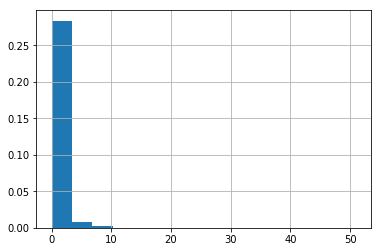

In [132]:
describe_missing('num_accts_ever_120_pd')

We fill missing values in `num_accts_ever_120_pd` with the median due to the skew.

In [133]:
X_test['num_accts_ever_120_pd'].fillna(X_train['num_accts_ever_120_pd'].median(), inplace=True)
X_train['num_accts_ever_120_pd'].fillna(X_train['num_accts_ever_120_pd'].median(), inplace=True)

#### `num_actv_bc_tl`

In [134]:
# find column with most missing values
X_train.count().idxmin()

'num_actv_bc_tl'

0.085330100112
count    543163.000000
mean          3.633187
std           2.187209
min           0.000000
25%           2.000000
50%           3.000000
75%           5.000000
max          33.000000
Name: num_actv_bc_tl, dtype: float64
0    0.84597
1    0.15403
Name: loan_status, dtype: float64


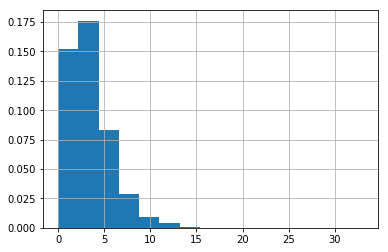

In [135]:
describe_missing('num_actv_bc_tl')

We fill missing values in `num_actv_bc_tl` with the median due to the slight skew and because these values are integers, not floats.

In [136]:
X_test['num_actv_bc_tl'].fillna(X_train['num_actv_bc_tl'].median(), inplace=True)
X_train['num_actv_bc_tl'].fillna(X_train['num_actv_bc_tl'].median(), inplace=True)

#### `num_actv_rev_tl`

In [137]:
# find column with most missing values
X_train.count().idxmin()

'num_actv_rev_tl'

0.085330100112
count    543163.000000
mean          5.650779
std           3.207430
min           0.000000
25%           3.000000
50%           5.000000
75%           7.000000
max          57.000000
Name: num_actv_rev_tl, dtype: float64
0    0.84597
1    0.15403
Name: loan_status, dtype: float64


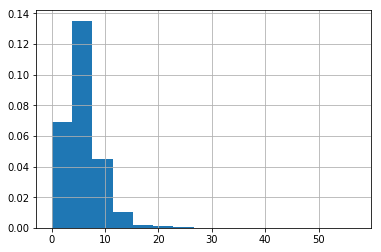

In [138]:
describe_missing('num_actv_rev_tl')

We fill missing values in `num_actv_rev_tl` with the median due to the slight skew and because these are integers, not floats.

In [139]:
X_test['num_actv_rev_tl'].fillna(X_train['num_actv_rev_tl'].median(), inplace=True)
X_train['num_actv_rev_tl'].fillna(X_train['num_actv_rev_tl'].median(), inplace=True)

#### `num_bc_tl`

In [140]:
# find column with most missing values
X_train.count().idxmin()

'num_bc_tl'

0.085330100112
count    543163.000000
mean          8.439502
std           4.872459
min           0.000000
25%           5.000000
50%           8.000000
75%          11.000000
max          68.000000
Name: num_bc_tl, dtype: float64
0    0.84597
1    0.15403
Name: loan_status, dtype: float64


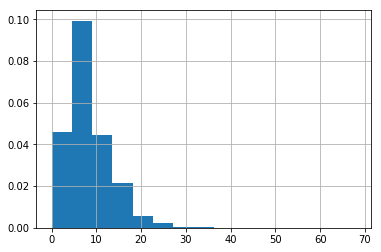

In [141]:
describe_missing('num_bc_tl')

We fill missing values in `num_bc_tl` with the median due to the skew.

In [142]:
X_test['num_bc_tl'].fillna(X_train['num_bc_tl'].median(), inplace=True)
X_train['num_bc_tl'].fillna(X_train['num_bc_tl'].median(), inplace=True)

#### `num_il_tl`

In [143]:
# find column with most missing values
X_train.count().idxmin()

'num_il_tl'

0.085330100112
count    543163.000000
mean          8.617016
std           7.345665
min           0.000000
25%           4.000000
50%           7.000000
75%          11.000000
max         128.000000
Name: num_il_tl, dtype: float64
0    0.84597
1    0.15403
Name: loan_status, dtype: float64


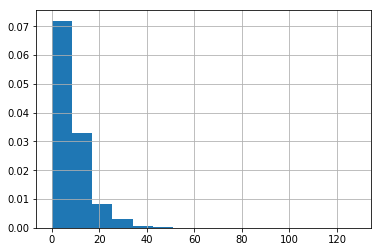

In [144]:
describe_missing('num_il_tl')

We fill missing values in `num_il_tl` with the median due to the slight skew.

In [145]:
X_test['num_il_tl'].fillna(X_train['num_il_tl'].median(), inplace=True)
X_train['num_il_tl'].fillna(X_train['num_il_tl'].median(), inplace=True)

#### `num_op_rev_tl`

In [146]:
# find column with most missing values
X_train.count().idxmin()

'num_op_rev_tl'

0.085330100112
count    543163.000000
mean          8.295589
std           4.432782
min           0.000000
25%           5.000000
50%           7.000000
75%          10.000000
max          79.000000
Name: num_op_rev_tl, dtype: float64
0    0.84597
1    0.15403
Name: loan_status, dtype: float64


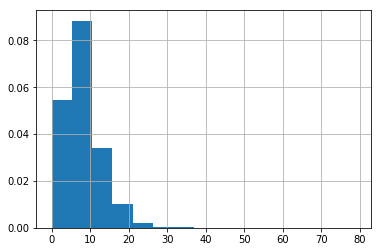

In [147]:
describe_missing('num_op_rev_tl')

We fill missing values in `num_op_rev_tl` with the median due to the skew and due to each value being an integer, not a float.

In [148]:
X_test['num_op_rev_tl'].fillna(X_train['num_op_rev_tl'].median(), inplace=True)
X_train['num_op_rev_tl'].fillna(X_train['num_op_rev_tl'].median(), inplace=True)

#### `num_rev_tl_bal_gt_0`

In [149]:
# find column with most missing values
X_train.count().idxmin()

'num_rev_tl_bal_gt_0'

0.085330100112
count    543163.000000
mean          5.608022
std           3.138869
min           0.000000
25%           3.000000
50%           5.000000
75%           7.000000
max          43.000000
Name: num_rev_tl_bal_gt_0, dtype: float64
0    0.84597
1    0.15403
Name: loan_status, dtype: float64


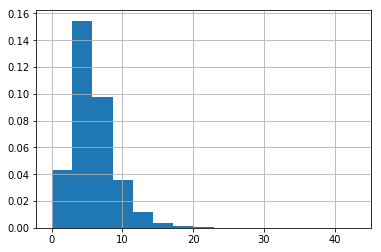

In [150]:
describe_missing('num_rev_tl_bal_gt_0')

We fill missing values in `num_rev_tl_bal_gt_0` with the median (each value is an integer).

In [151]:
X_test['num_rev_tl_bal_gt_0'].fillna(np.round(X_train['num_rev_tl_bal_gt_0'].mean(), 1), inplace=True)
X_train['num_rev_tl_bal_gt_0'].fillna(np.round(X_train['num_rev_tl_bal_gt_0'].mean(), 1), inplace=True)

#### `num_tl_op_past_12m`

In [152]:
# find column with most missing values
X_train.count().idxmin()

'num_tl_op_past_12m'

0.085330100112
count    543163.000000
mean          2.204441
std           1.824775
min           0.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          30.000000
Name: num_tl_op_past_12m, dtype: float64
0    0.84597
1    0.15403
Name: loan_status, dtype: float64


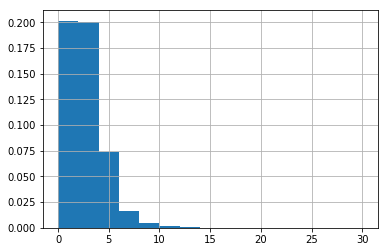

In [153]:
describe_missing('num_tl_op_past_12m')

We fill missing values in `num_tl_op_past_12m` with the median (each value is an integer).

In [154]:
X_test['num_tl_op_past_12m'].fillna(X_train['num_tl_op_past_12m'].median(), inplace=True)
X_train['num_tl_op_past_12m'].fillna(X_train['num_tl_op_past_12m'].median(), inplace=True)

#### `tot_coll_amt`

In [155]:
# find column with most missing values
X_train.count().idxmin()

'tot_coll_amt'

0.085330100112
count    5.431630e+05
mean     2.351392e+02
std      1.256743e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      9.152545e+06
Name: tot_coll_amt, dtype: float64
0    0.84597
1    0.15403
Name: loan_status, dtype: float64


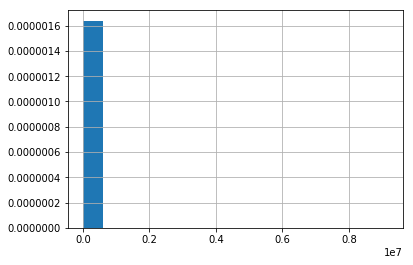

In [156]:
describe_missing('tot_coll_amt')

In [157]:
df['tot_coll_amt'].value_counts(normalize=True).iloc[:10]

0.0      0.855660
50.0     0.002055
100.0    0.001676
75.0     0.001279
200.0    0.000900
150.0    0.000886
60.0     0.000853
80.0     0.000721
70.0     0.000693
65.0     0.000632
Name: tot_coll_amt, dtype: float64

We fill missing values in `tot_coll_amt` with 0.

In [158]:
X_test['tot_coll_amt'].fillna(0, inplace=True)
X_train['tot_coll_amt'].fillna(0, inplace=True)

#### `tot_cur_bal`

In [159]:
# find column with most missing values
X_train.count().idxmin()

'tot_cur_bal'

0.085330100112
count    5.431630e+05
mean     1.407984e+05
std      1.552424e+05
min      0.000000e+00
25%      2.967800e+04
50%      8.168900e+04
75%      2.105115e+05
max      8.000078e+06
Name: tot_cur_bal, dtype: float64
0    0.84597
1    0.15403
Name: loan_status, dtype: float64


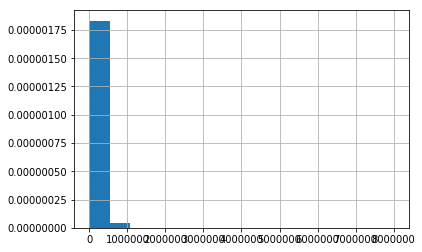

In [160]:
describe_missing('tot_cur_bal')

We fill missing values in `tot_cur_bal` with the median due to the skew.

In [161]:
X_test['tot_cur_bal'].fillna(X_train['tot_cur_bal'].median(), inplace=True)
X_train['tot_cur_bal'].fillna(X_train['tot_cur_bal'].median(), inplace=True)

#### `tot_hi_cred_lim`

In [162]:
# find column with most missing values
X_train.count().idxmin()

'tot_hi_cred_lim'

0.085330100112
count    5.431630e+05
mean     1.724986e+05
std      1.738637e+05
min      0.000000e+00
25%      4.904600e+04
50%      1.124590e+05
75%      2.501030e+05
max      9.999999e+06
Name: tot_hi_cred_lim, dtype: float64
0    0.84597
1    0.15403
Name: loan_status, dtype: float64


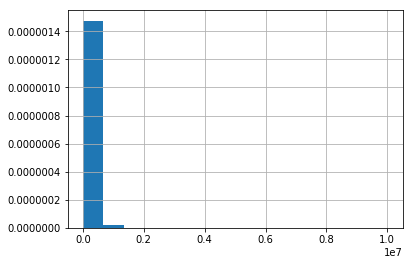

In [163]:
describe_missing('tot_hi_cred_lim')

We fill missing values in `tot_hi_cred_lim` with the median due to the skew.

In [164]:
X_test['tot_hi_cred_lim'].fillna(X_train['tot_hi_cred_lim'].median(), inplace=True)
X_train['tot_hi_cred_lim'].fillna(X_train['tot_hi_cred_lim'].median(), inplace=True)

#### `total_il_high_credit_limit`

In [165]:
# find column with most missing values
X_train.count().idxmin()

'total_il_high_credit_limit'

0.085330100112
count    5.431630e+05
mean     4.090327e+04
std      4.212211e+04
min      0.000000e+00
25%      1.421900e+04
50%      3.086100e+04
75%      5.504800e+04
max      2.101913e+06
Name: total_il_high_credit_limit, dtype: float64
0    0.84597
1    0.15403
Name: loan_status, dtype: float64


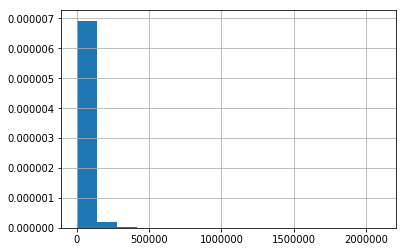

In [166]:
describe_missing('total_il_high_credit_limit')

We fill missing values in `total_il_high_credit_limit` with the median due to the skew.

In [167]:
X_test['total_il_high_credit_limit'].fillna(X_train['total_il_high_credit_limit'].median(), inplace=True)
X_train['total_il_high_credit_limit'].fillna(X_train['total_il_high_credit_limit'].median(), inplace=True)

#### `total_rev_hi_lim`

In [168]:
# find column with most missing values
X_train.count().idxmin()

'total_rev_hi_lim'

0.085330100112
count    5.431630e+05
mean     3.178159e+04
std      3.742383e+04
min      0.000000e+00
25%      1.380000e+04
50%      2.345000e+04
75%      3.940000e+04
max      9.999999e+06
Name: total_rev_hi_lim, dtype: float64
0    0.84597
1    0.15403
Name: loan_status, dtype: float64


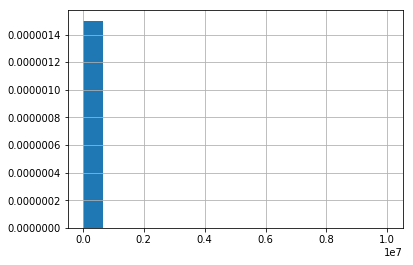

In [169]:
describe_missing('total_rev_hi_lim')

We fill missing values in `total_rev_hi_lim` with the median due to the skew

In [170]:
X_test['total_rev_hi_lim'].fillna(X_train['total_rev_hi_lim'].median(), inplace=True)
X_train['total_rev_hi_lim'].fillna(X_train['total_rev_hi_lim'].median(), inplace=True)

#### `num_bc_sats`

In [171]:
# find column with most missing values
X_train.count().idxmin()

'num_bc_sats'

0.0705381124386
count    551947.000000
mean          4.709579
std           2.851884
min           0.000000
25%           3.000000
50%           4.000000
75%           6.000000
max          57.000000
Name: num_bc_sats, dtype: float64
0    0.85158
1    0.14842
Name: loan_status, dtype: float64


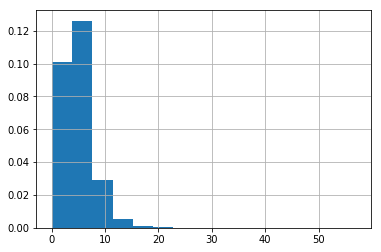

In [172]:
describe_missing('num_bc_sats')

We fill missing values in `num_bc_sats` with the median (each value is an integer).

In [173]:
X_test['num_bc_sats'].fillna(X_train['num_bc_sats'].median(), inplace=True)
X_train['num_bc_sats'].fillna(X_train['num_bc_sats'].median(), inplace=True)

#### `num_sats`

In [174]:
# find column with most missing values
X_train.count().idxmin()

'num_sats'

0.0705381124386
count    551947.000000
mean         11.621304
std           5.332673
min           0.000000
25%           8.000000
50%          11.000000
75%          14.000000
max          84.000000
Name: num_sats, dtype: float64
0    0.85158
1    0.14842
Name: loan_status, dtype: float64


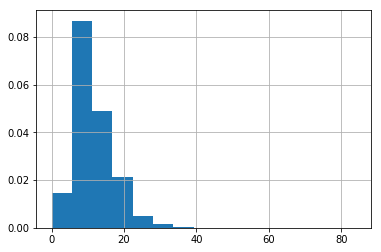

In [175]:
describe_missing('num_sats')

We fill missing values in `num_sats` with the median (each value is an integer).

In [176]:
X_test['num_sats'].fillna(X_train['num_sats'].median(), inplace=True)
X_train['num_sats'].fillna(X_train['num_sats'].median(), inplace=True)

#### `bc_util`

In [177]:
# find column with most missing values
X_train.count().idxmin()

'bc_util'

0.0700329216028
count    552247.000000
mean         61.555513
std          27.914193
min           0.000000
25%          40.700000
50%          65.400000
75%          86.000000
max         339.600000
Name: bc_util, dtype: float64
0    0.843128
1    0.156872
Name: loan_status, dtype: float64


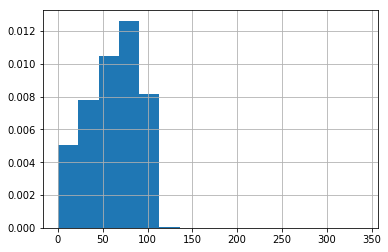

In [178]:
describe_missing('bc_util')

We fill missing values in `bc_util` with the mean (rounded to one decimal).

In [179]:
X_test['bc_util'].fillna(np.round(X_train['bc_util'].mean(), 1), inplace=True)
X_train['bc_util'].fillna(np.round(X_train['bc_util'].mean(), 1), inplace=True)

#### `percent_bc_gt_75`

In [180]:
# find column with most missing values
X_train.count().idxmin()

'percent_bc_gt_75'

0.0697937979405
count    552389.000000
mean         47.244879
std          35.652765
min           0.000000
25%          16.700000
50%          50.000000
75%          75.000000
max         100.000000
Name: percent_bc_gt_75, dtype: float64
0    0.84329
1    0.15671
Name: loan_status, dtype: float64


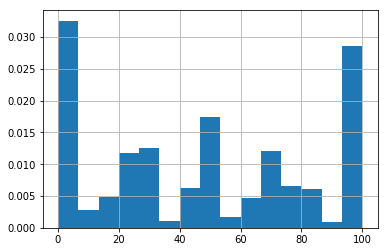

In [181]:
describe_missing('percent_bc_gt_75')

We fill missing values in `percent_bc_gt_75` with the median (the data is evenly spread).

In [182]:
X_test['percent_bc_gt_75'].fillna(X_train['percent_bc_gt_75'].median(), inplace=True)
X_train['percent_bc_gt_75'].fillna(X_train['percent_bc_gt_75'].median(), inplace=True)

#### `bc_open_to_buy`

In [183]:
# find column with most missing values
X_train.count().idxmin()

'bc_open_to_buy'

0.0694485842027
count    552594.000000
mean       9480.448722
std       14585.079230
min           0.000000
25%        1308.000000
50%        4261.000000
75%       11357.000000
max      497445.000000
Name: bc_open_to_buy, dtype: float64
0    0.843651
1    0.156349
Name: loan_status, dtype: float64


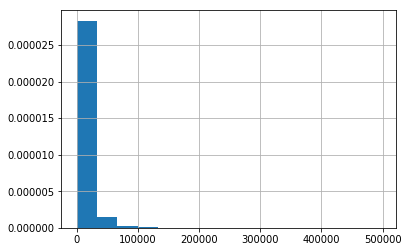

In [184]:
describe_missing('bc_open_to_buy')

We fill missing values in `bc_open_to_buy` with the median due to the skew.

In [185]:
X_test['bc_open_to_buy'].fillna(X_train['bc_open_to_buy'].median(), inplace=True)
X_train['bc_open_to_buy'].fillna(X_train['bc_open_to_buy'].median(), inplace=True)

#### `mths_since_recent_bc`

In [186]:
# find column with most missing values
X_train.count().idxmin()

'mths_since_recent_bc'

0.0687413170325
count    553014.000000
mean         23.363157
std          29.610121
min           0.000000
25%           6.000000
50%          13.000000
75%          28.000000
max         611.000000
Name: mths_since_recent_bc, dtype: float64
0    0.844124
1    0.155876
Name: loan_status, dtype: float64


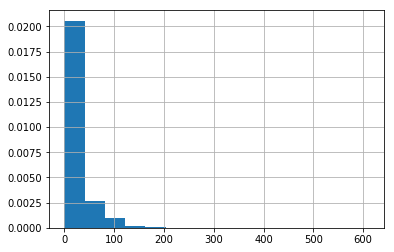

In [187]:
describe_missing('mths_since_recent_bc')

We fill missing values in `mths_since_recent_bc` with the median due to the skew.

In [188]:
X_test['mths_since_recent_bc'].fillna(X_train['mths_since_recent_bc'].median(), inplace=True)
X_train['mths_since_recent_bc'].fillna(X_train['mths_since_recent_bc'].median(), inplace=True)

#### `acc_open_past_24mths`

In [189]:
# find column with most missing values
X_train.count().idxmin()

'acc_open_past_24mths'

0.0597607079408
count    558347.000000
mean          4.716893
std           3.146605
min           0.000000
25%           2.000000
50%           4.000000
75%           6.000000
max          56.000000
Name: acc_open_past_24mths, dtype: float64
0    0.853641
1    0.146359
Name: loan_status, dtype: float64


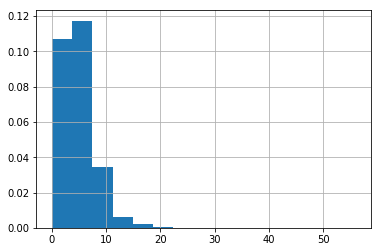

In [190]:
describe_missing('acc_open_past_24mths')

We fill missing values in `acc_open_past_24mths` with the median (each value is an integer).

In [191]:
X_test['acc_open_past_24mths'].fillna(X_train['acc_open_past_24mths'].median(), inplace=True)
X_train['acc_open_past_24mths'].fillna(X_train['acc_open_past_24mths'].median(), inplace=True)

#### `mort_acc`

In [192]:
# find column with most missing values
X_train.count().idxmin()

'mort_acc'

0.0597607079408
count    558347.000000
mean          1.762359
std           2.086743
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          51.000000
Name: mort_acc, dtype: float64
0    0.853641
1    0.146359
Name: loan_status, dtype: float64


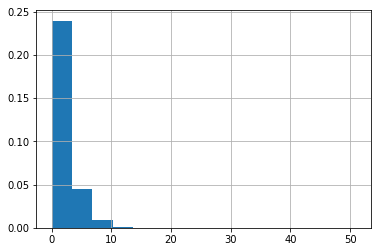

In [193]:
describe_missing('mort_acc')

We fill missing values in `mort_acc` with the median (each value is an integer).

In [194]:
X_test['mort_acc'].fillna(X_train['mort_acc'].median(), inplace=True)
X_train['mort_acc'].fillna(X_train['mort_acc'].median(), inplace=True)

#### `total_bal_ex_mort`

In [195]:
# find column with most missing values
X_train.count().idxmin()

'total_bal_ex_mort'

0.0597607079408
count    5.583470e+05
mean     4.860541e+04
std      4.622896e+04
min      0.000000e+00
25%      2.075700e+04
50%      3.678500e+04
75%      6.126300e+04
max      2.688920e+06
Name: total_bal_ex_mort, dtype: float64
0    0.853641
1    0.146359
Name: loan_status, dtype: float64


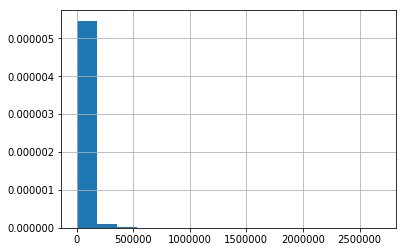

In [196]:
describe_missing('total_bal_ex_mort')

We fill missing values in `total_bal_ex_mort` with the median due to the skew.

In [197]:
X_test['total_bal_ex_mort'].fillna(X_train['total_bal_ex_mort'].median(), inplace=True)
X_train['total_bal_ex_mort'].fillna(X_train['total_bal_ex_mort'].median(), inplace=True)

#### `total_bc_limit`

In [198]:
# find column with most missing values
X_train.count().idxmin()

'total_bc_limit'

0.0597607079408
count    5.583470e+05
mean     2.082766e+04
std      2.073160e+04
min      0.000000e+00
25%      7.500000e+03
50%      1.450000e+04
75%      2.710000e+04
max      1.105500e+06
Name: total_bc_limit, dtype: float64
0    0.853641
1    0.146359
Name: loan_status, dtype: float64


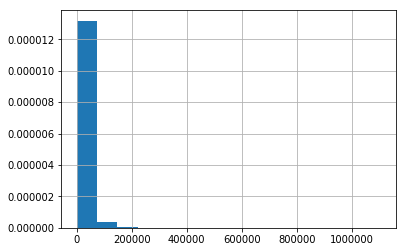

In [199]:
describe_missing('total_bc_limit')

We fill missing values in `total_bc_limit` with the median due to the skew.

In [200]:
X_test['total_bc_limit'].fillna(X_train['total_bc_limit'].median(), inplace=True)
X_train['total_bc_limit'].fillna(X_train['total_bc_limit'].median(), inplace=True)

#### `pub_rec_bankruptcies`

In [201]:
# find column with most missing values
X_train.count().idxmin()

'pub_rec_bankruptcies'

0.00090429159615
count    593298.000000
mean          0.131318
std           0.373860
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           9.000000
Name: pub_rec_bankruptcies, dtype: float64
0    0.83054
1    0.16946
Name: loan_status, dtype: float64


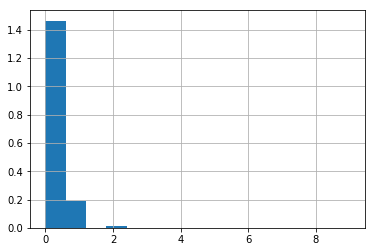

In [202]:
describe_missing('pub_rec_bankruptcies')

We fill missing values in `pub_rec_bankruptcies` with 0.

In [203]:
X_test['pub_rec_bankruptcies'].fillna(0, inplace=True)
X_train['pub_rec_bankruptcies'].fillna(0, inplace=True)

#### `revol_util`

In [204]:
# find column with most missing values
X_train.count().idxmin()

'revol_util'

0.000601177094648
count    593478.000000
mean          0.530023
std           0.243338
min           0.000000
25%           0.350000
50%           0.537000
75%           0.719000
max           3.666000
Name: revol_util, dtype: float64
0    0.778711
1    0.221289
Name: loan_status, dtype: float64


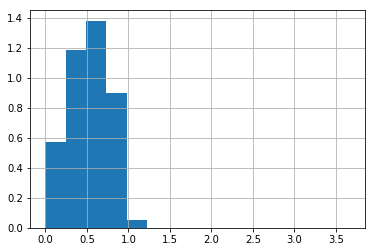

In [205]:
describe_missing('revol_util')

We fill missing values in `revol_util` with the mean.

In [206]:
X_test['revol_util'].fillna(X_train['revol_util'].mean(), inplace=True)
X_train['revol_util'].fillna(X_train['revol_util'].mean(), inplace=True)

#### `dti`

In [207]:
# find column with most missing values
X_train.count().idxmin()

'dti'

4.54671752254e-05
count    593808.000000
mean         17.842850
std           9.031508
min          -1.000000
25%          11.620000
50%          17.320000
75%          23.590000
max         999.000000
Name: dti, dtype: float64
0    0.888889
1    0.111111
Name: loan_status, dtype: float64


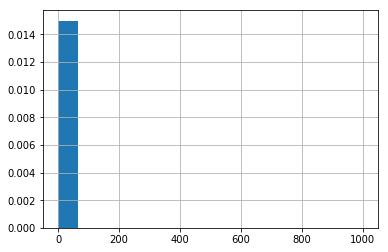

In [208]:
describe_missing('dti')

We fill missing values in `dti` with the median.

In [209]:
X_test['dti'].fillna(X_train['dti'].median(), inplace=True)
X_train['dti'].fillna(X_train['dti'].median(), inplace=True)

#### `inq_last_6mths`

In [211]:
# find column with most missing values
X_train.count().idxmin()

'inq_last_6mths'

1.68396945279e-06
count    593834.000000
mean          0.725182
std           0.991004
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           8.000000
Name: inq_last_6mths, dtype: float64
0    1.0
Name: loan_status, dtype: float64


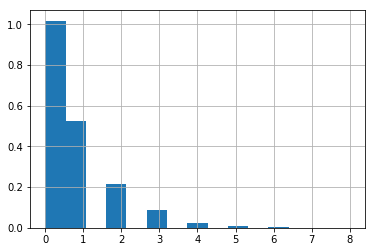

In [212]:
describe_missing('inq_last_6mths')

We fill missing values in `inq_last_6mths` with 0.

In [216]:
X_test['inq_last_6mths'].fillna(0, inplace=True)
X_train['inq_last_6mths'].fillna(0, inplace=True)

Check for any last missing values.

In [221]:
X_train.isnull().any().sum(), X_test.isnull().any().sum()

(0, 0)

Save the train and test splits to csv files.

In [222]:
X_train.to_csv("X_train.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)